# 11) Higher Order Analysis

In [1]:
# General analysis
import numpy as np
import pandas as pd
from itertools import combinations

# For coputala transformation
import scipy.special

# For PCA
from sklearn.decomposition import PCA

# For plotting and visualizations
import matplotlib.pyplot as plt

# For neuroimaging visualizations
from nilearn.plotting import plot_markers
import matplotlib.pyplot as plt

# For Shapiro-Wilk P-Values Comparison
from scipy.stats import shapiro

# For higher order interactions
from hoi.core import get_entropy, get_mi
from IPython.display import display
from hoi.metrics import Oinfo, Sinfo, GradientOinfo, TC, DTC, RSI, SynergyphiID, RedundancyphiID, SynergyMMI, RedundancyMMI
from hoi.utils import get_nbest_mult
import pickle

# Suppress warnings to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

## HighOrderInfoAnalyzer Class

The `HighOrderInfoAnalyzer` class enables detailed exploration of high-order interactions in multivariate time series data using information-theoretic quantities. It is particularly useful for understanding redundancy, synergy, and mutual dependence among groups of variables (e.g., brain regions, sensors, or features).

---

### Features

- Analyze all n-plets (e.g., triplets, quadruplets) from multivariate data.
- Supports high-order metrics like:
  - O-Information
  - S-Information
  - Total Correlation
  - Dual Total Correlation
- Computes:
  - Univariate and joint entropy
  - Pairwise and groupwise mutual information
  - Conditional mutual information
  - Bipartition mutual information across all splits
- Accepts precomputed data to avoid redundant computations.
- Compatible with KNN-based estimators.

---

### Parameters

#### `__init__(data, n)`

| Parameter | Type              | Description                                                              |
| --------- | ----------------- | ------------------------------------------------------------------------ |
| `data`    | `ndarray` (N × T) | Time series data with `N` modules (rows) and `T` time samples (columns). |
| `n`       | `int`             | Size of the n-plets to analyze (e.g., 3 for triplets).                   |

---

### Methods

1. **`run(precomputed_oinfo=None, precomputed_sinfo=None, precomputed_TC=None, precomputed_DTC=None)`**  
   - Loads and stores precomputed Oinfo, Sinfo, TC, DTC DataFrames.  
   - Returns these metrics if provided.

2. **`trace_subset(target_subset)`**  
   - Accepts a list of specific n-plets (e.g., `[(0, 1, 2)]`).  
   - Returns detailed info-theoretic analysis including:  
     - Redundancy/synergy values  
     - Entropy and mutual information tables  
     - Bipartition mutual information for each subset

3. **`compute_uni_entropies()`**  
   - Returns: Dictionary `{i: entropy_value}` for each module `i`.

4. **`compute_multi_entropy(multiplet)`**  
   - Returns: Joint entropy of a given n-plet.

5. **`compute_pairwise_mi(multiplet)`**  
   - Returns: Mutual information between all pairs in the n-plet.

6. **`compute_all_pairwise_cmi(multiplet)`**  
   - Returns: Conditional mutual information for all triplet permutations `(i, j | k)`.

7. **`compute_groupwise_cmi(multiplet)`**  
   - Returns: Conditional mutual information of each variable conditioned on the rest `(i | rest)`.

8. **`compute_all_bipartitions_mi(multiplet, mi_func="knn")`**  
   - Returns: Mutual information for all bipartitions of the n-plet grouped by split size `r`.

9. **`compute_joint_mi(group1, group2, mi_func="knn")`**  
   - Returns: Mutual information between two groups of variables.

### Key Outputs
Each result from trace_subset() returns a dictionary containing:

| Output                | Description                                           |
| --------------------- | ----------------------------------------------------- |
| `nplet`               | Tuple of module indices                               |
| `Oinfo`               | O-Information value (synergy vs redundancy indicator) |
| `Sinfo`               | S-Information (shared information)                    |
| `TC`                  | Total Correlation                                     |
| `DTC`                 | Dual Total Correlation                                |
| `entropy_clean`       | Dictionary of univariate entropies                    |
| `entropy_mult`        | Joint entropy of the full n-plet                      |
| `mi_clean`            | Dictionary of pairwise mutual information             |
| `cmi_clean`           | Conditional MI for all 3-variable permutations        |
| `groupwise_cmi_clean` | CMI of each variable conditioned on the others        |
| `joint_mi_results`    | Mutual Information across all bipartitions            |

---

### Usage Example

```python
from high_order import HighOrderInfoAnalyzer  # Assuming your class is saved in high_order.py

# Initialize
analyzer = HighOrderInfoAnalyzer(data=my_data, n=3)

# Load precomputed values if available
oinfo, sinfo, tc, dtc = analyzer.run(
    precomputed_oinfo=oinfo_df,
    precomputed_sinfo=sinfo_df,
    precomputed_TC=tc_df,
    precomputed_DTC=dtc_df
)

# Analyze specific n-plets
results = analyzer.trace_subset([(0, 1, 2), (3, 4, 5)])

In [2]:
class HighOrderInfoAnalyzer:
    
    def __init__(self, data, n):
        """
        Parameters:
        - data: ndarray (N modules x T samples)
        - n: size of n-plets (e.g., 3 for triplets)
        """
        self.data = data
        self.n = n
        self.modules = data.shape[0]
        self.samples = data.shape[1]
        self.nplets = list(combinations(range(self.modules), self.n))
        
    def run(self, precomputed_oinfo=None, precomputed_sinfo=None, precomputed_TC=None, precomputed_DTC=None):
        if all(v is not None for v in [precomputed_oinfo, precomputed_sinfo, precomputed_TC, precomputed_DTC]):
            self.Oinfo = precomputed_oinfo
            self.Sinfo = precomputed_sinfo
            self.TC = precomputed_TC
            self.DTC = precomputed_DTC
            return self.Oinfo, self.Sinfo, self.TC, self.DTC
        
        
    def trace_subset(self, target_subset):
        entropy_dict = self.compute_uni_entropies()
        results = []

        for nplet in target_subset:
            if nplet not in self.nplets:
                continue

            nplet_str = str(nplet)

            o_value = self._get_info_value(self.Oinfo, nplet_str, "Synergistic Multiplet", "Synergistic Value", 
                                           "Redundant Multiplet", "Redundant Value")
            S_value = self._get_info_value(self.Sinfo, nplet_str, "Synergistic Multiplet", "Shared Information (S)", 
                                           "Redundant Multiplet", "Shared Information (R)")
            tc_value = self._get_info_value(self.TC, nplet_str, "Synergistic Multiplet", "Total Correlation (S)", 
                                            "Redundant Multiplet", "Total Correlation (R)")
            dtc_value = self._get_info_value(self.DTC, nplet_str, "Synergistic Multiplet", "Dual Total Correlation (S)", 
                                             "Redundant Multiplet", "Dual Total Correlation (R)")

            entropy_clean = {k: f"{float(v):.4f}" for k, v in entropy_dict.items() if k in nplet}
            entropy_mult = float(self.compute_multi_entropy(nplet))
            mi_clean = {pair: f"{val:.4f}" for pair, val in self.compute_pairwise_mi(nplet).items()}
            cmi_clean = {f"{i},{j} | {k}": f"{val}" for (i, j, k), val in self.compute_all_pairwise_cmi(nplet).items()}
            groupwise_cmi_clean = {
                f"{vars_} | {cond}": f"{val:.4f}" for (vars_, cond), val in self.compute_groupwise_cmi(nplet).items()
            }
            joint_mi_results = self.compute_all_bipartitions_mi(nplet)

            results.append((
                nplet, o_value, S_value, tc_value, dtc_value, 
                entropy_clean, entropy_mult, mi_clean, 
                cmi_clean, groupwise_cmi_clean, joint_mi_results
            ))

        return results
    
    def _get_info_value(self, df, nplet_str, pos_col, pos_val_col, neg_col, neg_val_col):
        row = df[df[pos_col].astype(str) == nplet_str]
        if not row.empty:
            return row[pos_val_col].values[0]
        row = df[df[neg_col].astype(str) == nplet_str]
        return row[neg_val_col].values[0] if not row.empty else None
    
    def compute_uni_entropies(self):
        self.entropy_dict = {
            i: get_entropy("knn")(self.data[i:i+1, :].copy())
            for i in range(self.modules)
        }
        return self.entropy_dict

    def compute_multi_entropy(self, multiplet):
        x = self.data[list(multiplet), :]
        return float(get_entropy("knn")(x.copy()))
    
    def compute_pairwise_mi(self, multiplet):
        return {
            (i, j): float(get_mi("knn")(self.data[i:i+1, :].copy(), self.data[j:j+1, :].copy()))
            for i, j in combinations(multiplet, 2)
        }
    
    def compute_all_pairwise_cmi(self, multiplet):
        cmi_results = {}
        for i, j, k in combinations(multiplet, 3):
            x_i, x_j, x_k = [self.data[x, :].reshape(1, -1) for x in (i, j, k)]
            cmi_results[(i, j, k)] = f"{float(get_mi('knn')(np.vstack([x_i, x_j]), x_k)):.4f}"
            cmi_results[(i, k, j)] = f"{float(get_mi('knn')(np.vstack([x_i, x_k]), x_j)):.4f}"
            cmi_results[(j, k, i)] = f"{float(get_mi('knn')(np.vstack([x_j, x_k]), x_i)):.4f}"
        return cmi_results
    
    def compute_groupwise_cmi(self, multiplet):
        cmi_results = {}
        for i, cond in enumerate(multiplet):
            sources = [multiplet[j] for j in range(len(multiplet)) if j != i]
            x_sources = np.vstack([self.data[s, :].reshape(1, -1) for s in sources])
            x_cond = self.data[cond, :].reshape(1, -1)
            cmi_results[(tuple(sources), cond)] = float(get_mi("knn")(x_sources, x_cond))
        return cmi_results


    def compute_all_bipartitions_mi(self, multiplet, mi_func="knn"):
        n = len(multiplet)
        results_by_r = {}

        for r in range(1, n):
            result = {}
            for group1 in combinations(multiplet, r):
                group2 = tuple(sorted(set(multiplet) - set(group1)))
                mi_val = self.compute_joint_mi(group1, group2, mi_func)
                
                if r == 1:
                    label = f"{group1[0]} | {group2}"
                elif r == n - 1:
                    label = f"{group1} | {group2[0]}"
                else:
                    label = f"{group1} | {group2}"

                result[label] = f"{mi_val:.4f}"
            results_by_r[r] = result

        return results_by_r
    
    def compute_joint_mi(self, group1, group2, mi_func="knn"):
        x_g1 = np.vstack([self.data[i, :].reshape(1, -1) for i in group1])
        x_g2 = np.vstack([self.data[i, :].reshape(1, -1) for i in group2])
        return float(get_mi(mi_func)(x_g1, x_g2))

## 11.1) Preparing Datasets
In this section, we perform dimensionality reduction on the time series data for each of the 20 brain network modules using Principal Component Analysis (PCA). For each module, we extract the associated regional time series and apply PCA to reduce the data to its first principal component (PC1), which captures the dominant pattern of activity within that module. These PC1 time series are then stored in mod_ts_pca, resulting in an array of shape (20, 190), where each row represents the dominant temporal dynamics of a module.

Next, we apply a copula transformation to the module-wise PCA time series using the ctransform function. This function operates row-wise and transforms the values in each module's time series into their empirical cumulative distribution ranks, scaled between 0 and 1. This is useful for making the data more robust to non-Gaussian distributions and for standardizing across modules.

Finally, we apply the copula normalization using the copnorm function, which transforms the copula-scaled data into a standard normal distribution using the inverse CDF (probit function). This step results in normalized_copulated_data, a matrix of the same shape (20, 190), but now with normalized values that are more suitable for further statistical analysis, such as connectivity or information-theoretic measures.

The ctransform and copnorm functions were adapted from the GCMI (Gaussian Copula Mutual Information) Python toolbox developed by Ince et al. https://github.com/robince/gcmi, which provides information-theoretic tools optimized for neural data analysis.

In [3]:
data = np.load("npz_files/brain_data.npz", allow_pickle=True)
rsFC_labels = data["rsFC_labels"]
time_series = data["time_series"]

In [4]:
mod_ts = []
for mod in range(1, 21):  # From 1 to 20
    indices = np.where(rsFC_labels == mod)[0]
    mod_ts.append(np.mean(time_series[:, indices], axis=1))
mod_ts = np.array(mod_ts)  # shape: (20, T)
print(mod_ts.shape)  # Output: (20, 190)

(20, 190)


In [5]:
mod_ts_pca = []
for mod in range(1, 21):
    indices = np.where(rsFC_labels == mod)[0]
    mod_data = time_series[:, indices]  # Shape: (190, N)
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(mod_data)  # Shape: (190, 1)
    mod_ts_pca.append(pc1[:, 0])  # Flatten
mod_ts_pca = np.array(mod_ts_pca)  # Shape: (20, 190)
print(mod_ts_pca.shape)

(20, 190)


In [6]:
def ctransform(x):
    """
    Apply copula transformation row-wise (along axis=1) for (modules x timepoints) data.
    Each row will be transformed independently.
    """
    x = np.atleast_2d(x)
    xi = np.argsort(x, axis=1)
    xr = np.argsort(xi, axis=1)
    cx = (xr + 1).astype(float) / (x.shape[1] + 1)
    return cx

copulated_data = ctransform(mod_ts_pca)  # data shape: (20, 190)
print(copulated_data.shape)

(20, 190)


In [7]:
def copnorm(x):
    # Apply copula transformation (empirical CDF)
    cx = scipy.special.ndtri(ctransform(x))  # Standard normal quantile (inverse CDF)
    return cx
normalized_copulated_data = copnorm(mod_ts_pca)  # data shape: (20, 190)
print(normalized_copulated_data.shape)

(20, 190)


In [8]:
# Save to npz file in the "npz_files" directory
np.savez('npz_files/modular_timeseries.npz',
         x_raw=mod_ts,
         x_raw_pca=mod_ts_pca,
         x_gauss=normalized_copulated_data)

print("Saved to 'npz_files/modular_timeseries.npz'")

Saved to 'npz_files/modular_timeseries.npz'


## 12) Testing Univariate and Multivariate Normality
In this section, we evaluate the normality of the module-wise time series data using both univariate and multivariate statistical tests. First, the univariate_normality_test function applies the Shapiro-Wilk test to each module's time series independently. This test assesses whether each module's time series is normally distributed. The results are captured as p-values, and for easier interpretation, we use emojis to flag whether each module passes (✅) or fails (❌) the normality test (using a threshold of p > 0.05 for normality). The results are summarized in a DataFrame comparing the raw averaged time series (mod_ts), the PCA-reduced data (mod_ts_pca), and the copula-normalized data (normalized_copulated_data).

Additionally, we assess multivariate normality using Mardia’s test, which calculates skewness and kurtosis on the multivariate distribution of the data (transposed so that time points are samples and modules are variables). For a dataset to be multivariate normal, skewness should be close to 0, and kurtosis should be close to the theoretical value of p(p + 2), where p is the number of variables (modules). This helps determine whether transformations such as PCA or copula normalization help in aligning the data more closely with the assumptions of multivariate Gaussianity — which is crucial for many statistical models and network analyses in neuroscience.

In [9]:
def univariate_normality_test(data, title="Data"):
    p_list = []
    #print(f"\n=== Shapiro-Wilk Test for {title} ===")
    normal_count = 0
    for i in range(data.shape[0]):
        x = data[i]
        stat, p = shapiro(x)
        result = "✅ Normal" if p > 0.05 else "❌ Not Normal"
        #print(f"  Module {i+1:2d}: W={stat:.4f}, p={p:.4f} {result}")
        if p > 0.05:
             normal_count += 1
        p_list.append(p)
    #print(f"  --> {normal_count}/{data.shape[0]} modules are univariate normal.\n")
    return p_list
    

def mardia_multivariate_test(title, data):
    """
    Mardia's multivariate normality test for multivariate data.
    Input shape should be (variables, samples) → transpose before testing.
    """
    from scipy.stats import kurtosis, skew

    data = data.T  # Now shape = (samples, variables)
    n, p = data.shape
    mean = data.mean(axis=0)
    centered = data - mean
    cov = np.cov(centered, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    D = np.einsum('ij,jk,ik->i', centered, inv_cov, centered)

    # Skewness and Kurtosis
    skewness = np.mean(D**3)
    kurt = np.mean(D**2)
    
    print(f"=== Mardia’s Multivariate Normality Test for {title} ===")
    print(f"  Skewness (should be ~0): {skewness:.4f}")
    print(f"  Kurtosis (should be ~{p*(p+2)}): {kurt:.4f}\n")

In [10]:
p_values_raw = univariate_normality_test(mod_ts)
p_values_copulated = univariate_normality_test(mod_ts_pca)
p_values_normalized = univariate_normality_test(normalized_copulated_data)

In [11]:
def add_normality_flags(p_values):
    """Returns list of formatted strings with p-value and emoji flag."""
    return [f"{p:.3f} ✅" if p > 0.05 else f"{p:.3f} ❌" for p in p_values]

# Wrap p-values with interpretation emojis
raw_flags = add_normality_flags(p_values_raw)
copulated_flags = add_normality_flags(p_values_copulated)
normalized_flags = add_normality_flags(p_values_normalized)

# Create DataFrame
df_shapiro = pd.DataFrame({
    'Module': [f'Module {i+1}' for i in range(len(p_values_raw))],
    'Raw ': raw_flags,
    ' Copulated ': copulated_flags,
    ' Normalized ': normalized_flags
})

# Set index
df_shapiro.set_index('Module', inplace=True)

# Display
print("\n=== Shapiro-Wilk P-Values Comparison with Normality Flags ===")
print(df_shapiro)


=== Shapiro-Wilk P-Values Comparison with Normality Flags ===
              Raw   Copulated   Normalized 
Module                                     
Module 1   0.369 ✅     0.367 ✅      1.000 ✅
Module 2   0.005 ❌     0.013 ❌      1.000 ✅
Module 3   0.357 ✅     0.116 ✅      1.000 ✅
Module 4   0.501 ✅     0.221 ✅      1.000 ✅
Module 5   0.257 ✅     0.437 ✅      1.000 ✅
Module 6   0.075 ✅     0.055 ✅      1.000 ✅
Module 7   0.325 ✅     0.004 ❌      1.000 ✅
Module 8   0.545 ✅     0.767 ✅      1.000 ✅
Module 9   0.905 ✅     0.896 ✅      1.000 ✅
Module 10  0.614 ✅     0.813 ✅      1.000 ✅
Module 11  0.049 ❌     0.055 ✅      1.000 ✅
Module 12  0.006 ❌     0.004 ❌      1.000 ✅
Module 13  0.175 ✅     0.278 ✅      1.000 ✅
Module 14  0.262 ✅     0.285 ✅      1.000 ✅
Module 15  0.183 ✅     0.627 ✅      1.000 ✅
Module 16  0.027 ❌     0.237 ✅      1.000 ✅
Module 17  0.399 ✅     0.497 ✅      1.000 ✅
Module 18  0.446 ✅     0.630 ✅      1.000 ✅
Module 19  0.058 ✅     0.053 ✅      1.000 ✅
Module 20  0.

In [12]:
datasets = {
    "Raw_Pca ": mod_ts_pca,
    "Raw ": mod_ts,
    "Normalized ": normalized_copulated_data
}

for title, data in datasets.items():
    mardia_multivariate_test(title= title, data= data)

=== Mardia’s Multivariate Normality Test for Raw_Pca  ===
  Skewness (should be ~0): 9734.0646
  Kurtosis (should be ~440): 425.2848

=== Mardia’s Multivariate Normality Test for Raw  ===
  Skewness (should be ~0): 9862.8496
  Kurtosis (should be ~440): 427.4520

=== Mardia’s Multivariate Normality Test for Normalized  ===
  Skewness (should be ~0): 9914.3425
  Kurtosis (should be ~440): 428.1443



## 13) Entropy

In this section, we evaluate the **information content** of different forms of brain module time series data by computing their **entropy** — a measure of uncertainty or complexity in the signal. We compare multiple entropy estimation techniques, including:

1. **Gaussian estimator** (assuming multivariate normality)  
2. **Histogram-based entropy**  
3. **Kernel density estimation**  
4. **K-nearest neighbors (KNN)** with *k=5* and *k=10*  
5. **Graph-based estimator (GC)**  

### Datasets

We perform both univariate and multivariate entropy estimation on three datasets:

- `x_raw`: Original module-averaged time series  
- `x_raw_pca`: First principal components of module data (copula-aligned)  
- `x_gauss`: Copula-normalized data, transformed to have standard normal marginals  

### Estimation Methods

1. **Univariate entropy** is computed for each module independently using each metric.  
2. **Multivariate entropy** is computed over the full set of modules, capturing joint statistical structure.  
3. **Analytical entropy** for multivariate Gaussian distributions is calculated from the covariance matrix and serves as a reference "ground truth."  

### Sample Size Analysis

To evaluate the robustness of each entropy estimator, we perform **repeated random sampling** across a range of sample sizes (from 10 to 190 time points), with 20 repetitions per sample size. This approach helps assess estimator reliability and convergence behavior.

### Visualization

We plot entropy as a function of sample size, comparing each estimator against the theoretical entropy (calculated analytically from the full dataset). This visualization allows us to assess:

- Biases or under/over-estimation by different estimators  
- Effects of data preprocessing (e.g., PCA, copula transformation)  
- Stability of entropy estimation with small sample sizes  

---

**Note:** In this and the following sections, we use the [Higher-Order Interactions (HOI) library](https://brainets.github.io/hoi/index.html) for entropy and information-theoretic computations. The HOI toolbox provides efficient implementations of various estimators, including Gaussian, histogram-based, KNN, kernel, and graph-based methods for both univariate and multivariate information measures. For more details, see the official documentation:  
*"HOI: A Python library for higher-order information theoretic analysis in neuroscience."* ([brainets.github.io/hoi](https://brainets.github.io/hoi/index.html))


### 13.1) Preparing Data

In [13]:
data = np.load('npz_files/modular_timeseries.npz')
x_raw = data['x_raw']
x_gauss = data['x_gauss']
x_raw_pca = data["x_raw_pca"]

### 13.2) Metrics and Entropy Function

In [14]:
metrics_ent = {
    "GC": get_entropy("gc"),
    "Gaussian": get_entropy("gauss"),
    "Histogram": get_entropy("histogram"),
    "KNN-5": get_entropy("knn", k=5),
    "KNN-10": get_entropy("knn", k=10),
    "Kernel": get_entropy("kernel"),
}

### 13.3) Functions for Computing, Plotting and Comparing Metrics

In [15]:
def univariate_entropy_calculator(x):

    entropy_values_gauss = []
    
    for i in range(x.shape[0]):
        entropy = metrics_ent["Gaussian"](x[i].reshape(1,-1))
        entropy_values_gauss.append(entropy)
    
    return entropy_values_gauss

def analytical_entropy_calculator(x):
    C = np.cov(x, rowvar=True)
    entropy_analytical = (
        0.5 * (np.log(np.linalg.det(C)) + 20 * (1 + np.log(2 * np.pi)))
    ) / np.log(2)
    return entropy_analytical

def univariate_entropy_calculator_all_metrics(x, metrics, title):
    """
    Her univariate sinyal için p-değeri 0.05'ten küçükse KNN, değilse diğer metriklerle entropy hesapla.
    Her metrik için ayrı ayrı entropileri döndürür.
    """
    n_metrics = metrics.keys()
    entropy_results = {m: [] for m in n_metrics}

    for i in range(x.shape[0]):
        for metric_name, metric_fn in metrics.items():
            entropy = metric_fn(x[i].reshape(1, -1))
            entropy_results[metric_name].append(entropy)

    # her metrik için toplam entropy'yi döndür
    entropy_totals = {m: np.sum(entropy_results[m]) for m in n_metrics}
    print(f"Entropy Values for {title} = ", entropy_totals)

def multivariate_entropy_calculator_all_metrics(x, metrics, title):
    n_metrics = metrics.keys()
    n_metrics = list(metrics.keys()) + ["Analytical"]
    entropy_results = {m: [] for m in n_metrics}
            
    for metric in metrics.keys():
        H = metrics[metric](x)
        entropy_results[metric].append(H)
        
    H_analytical = analytical_entropy_calculator(x)
    entropy_results["Analytical"].append(H_analytical)
    
    # her metrik için toplam entropy'yi döndür
    entropy_totals = {m: np.sum(entropy_results[m]) for m in n_metrics}
    print(f"Entropy Values for {title} = ", entropy_totals)
        
def run_entropy_comparison_all_metrics(x, n_samples, n_repeat, metrics):
    
    all_results = {m: [] for m in metrics.keys()}
    theoretical_entropies = []

    for s in n_samples:
        # Her örneklem boyutu için tekrarlıyoruz
        entropies_for_s = {m: [] for m in metrics.keys()}

        for _ in range(n_repeat):
            idx = np.random.choice(x.shape[1], size=s, replace=False)
            x_sampled = x[:, idx]

            entropies = univariate_entropy_calculator_all_metrics(x_sampled, metrics)
            for metric_name, value in entropies.items():
                entropies_for_s[metric_name].append(value)

        for m in metrics:
            all_results[m].append(entropies_for_s[m])

    return all_results

def run_multivariate_entropy_comparison(x_base, n_samples, n_repeat, metric_dict):
    all_results = {m: [] for m in metric_dict.keys()}

    for s in n_samples:
        entropies_for_s = {m: [] for m in metric_dict.keys()}

        for _ in range(n_repeat):
            idx = np.random.choice(x_base.shape[1], size=s, replace=False)
            x_sampled = x_base[:, idx]  # multivariate!

            for metric_name, metric_fn in metric_dict.items():
                entropy = metric_fn(x_sampled)  # direkt multivariate hesapla
                entropies_for_s[metric_name].append(entropy)

        for m in metric_dict:
            all_results[m].append(entropies_for_s[m])

    return all_results


def plot_entropy_metrics_comparison(n_samples, all_results, theoretical_constant):
    
    plt.figure(figsize=(10, 6))

    for i, (metric_name, values) in enumerate(all_results.items()):
        values = np.array(values)
        means = [np.mean(v) for v in values]
        perc5 = [np.percentile(v, 5) for v in values]
        perc95 = [np.percentile(v, 95) for v in values]

        color = f"C{i}"
        plt.plot(n_samples, means, label=metric_name, color=color, lw=2, marker='o')
        plt.fill_between(n_samples, perc5, perc95, alpha=0.2, color=color)

    # Sabit teorik entropi
    plt.axhline(theoretical_constant, linestyle="--", color="k", lw=2, label="Analytical (full data)")
    plt.xlabel("Number of Samples")
    plt.ylabel("Entropy [bits]")
    plt.title("Entropy Estimators vs Analytical Entropy", fontweight="bold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_entropy_metrics_comparison_side_by_side(
    n_samples,
    results_list,
    titles,
    analytical_constants
):
    n_panels = len(results_list)
    fig, axs = plt.subplots(1, n_panels, figsize=(7 * n_panels, 6), sharey=True)

    for i, (results, title, H_theoretical) in enumerate(zip(results_list, titles, analytical_constants)):
        ax = axs[i] if n_panels > 1 else axs

        for j, (metric_name, values) in enumerate(results.items()):
            values = np.array(values)
            means = [np.mean(v) for v in values]
            perc5 = [np.percentile(v, 5) for v in values]
            perc95 = [np.percentile(v, 95) for v in values]

            color = f"C{j}"
            ax.plot(n_samples, means, label=metric_name, color=color, lw=2, marker='o')
            ax.fill_between(n_samples, perc5, perc95, alpha=0.2, color=color)

        ax.axhline(H_theoretical, linestyle="--", color="k", lw=2, label="Analytical (full data)")
        ax.set_title(title, fontweight="bold")
        ax.set_xlabel("Number of Samples")
        ax.grid(True)
        if i == 0:
            ax.set_ylabel("Entropy [bits]")
        ax.legend()

    plt.tight_layout()
    plt.show()

In [16]:
for title, data in datasets.items():
    univariate_entropy_calculator_all_metrics(data, metrics_ent, title)

Entropy Values for Raw_Pca  =  {'GC': 40.403152, 'Gaussian': 181.15211, 'Histogram': 180.30077, 'KNN-5': 180.9213, 'KNN-10': 180.81377, 'Kernel': 180.59802}
Entropy Values for Raw  =  {'GC': 40.403152, 'Gaussian': 173.99127, 'Histogram': 109.90232, 'KNN-5': 110.922165, 'KNN-10': 110.5575, 'Kernel': 110.35287}
Entropy Values for Normalized  =  {'GC': 40.403152, 'Gaussian': 40.32669, 'Histogram': 40.37046, 'KNN-5': 47.20713, 'KNN-10': 42.006393, 'Kernel': 40.289207}


In [17]:
for title, data in datasets.items():
    multivariate_entropy_calculator_all_metrics(data, metrics_ent, title)

Entropy Values for Raw_Pca  =  {'GC': 28.379986, 'Gaussian': 167.8927, 'Histogram': 0.0, 'KNN-5': 179.73637, 'KNN-10': 181.85843, 'Kernel': inf, 'Analytical': 167.89269357358216}
Entropy Values for Raw  =  {'GC': 30.790783, 'Gaussian': 106.9154, 'Histogram': 64.44954, 'KNN-5': 111.039406, 'KNN-10': 113.121025, 'Kernel': 86.91405, 'Analytical': 100.09777011789058}
Entropy Values for Normalized  =  {'GC': 28.379986, 'Gaussian': 27.547905, 'Histogram': -5.30876, 'KNN-5': 36.54236, 'KNN-10': 38.493855, 'Kernel': 14.368591, 'Analytical': 27.547899231084315}


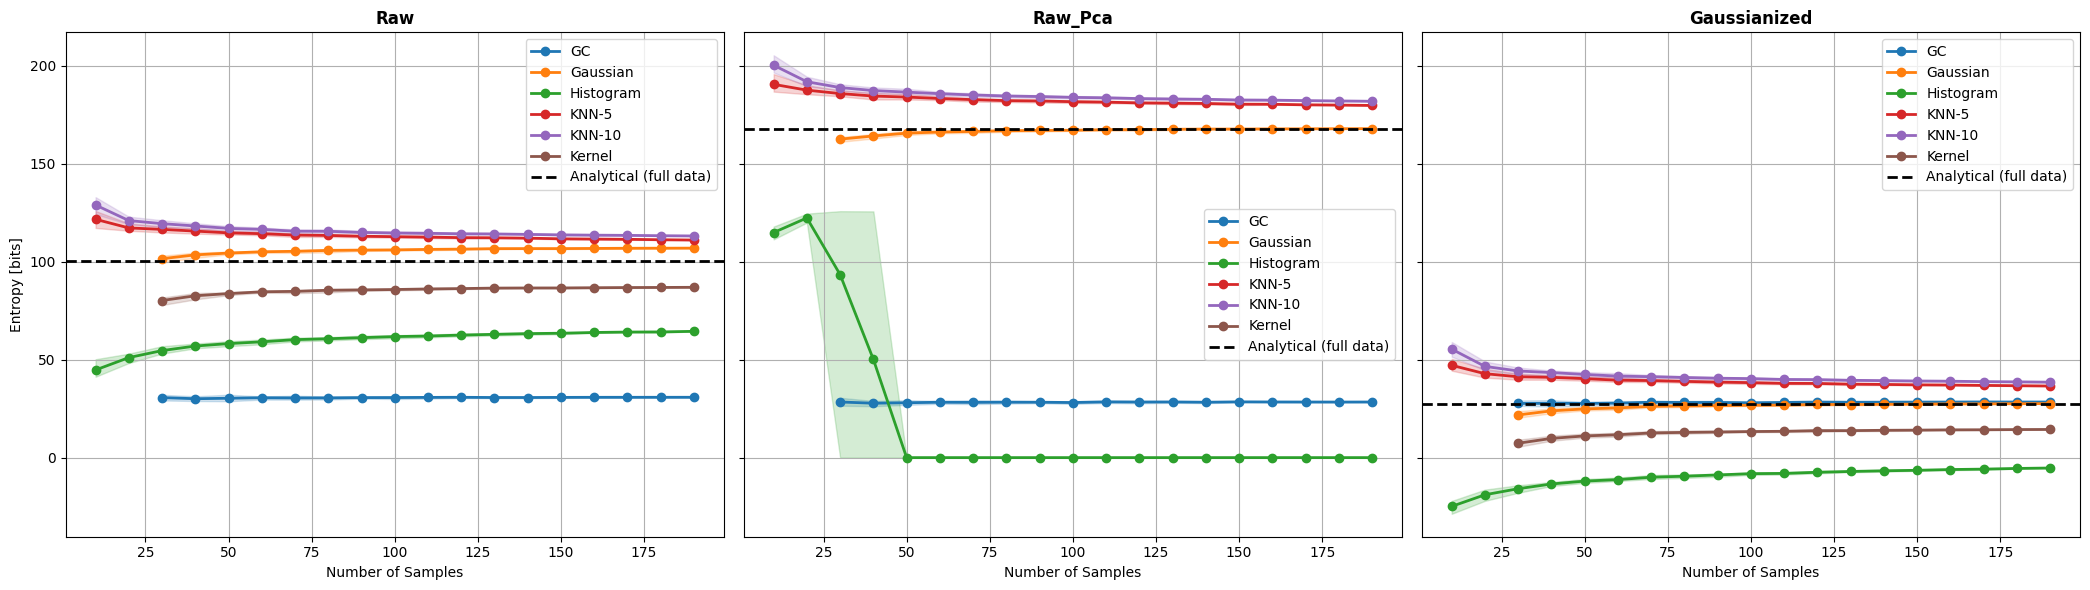

In [18]:
H_raw_analytical = analytical_entropy_calculator(x_raw)
H_copula_analytical = analytical_entropy_calculator(x_raw_pca)
H_gauss_analytical = analytical_entropy_calculator(x_gauss)

n_samples = np.arange(10, 191, 10)
n_repeat = 20

# Run your entropy comparisons
results_raw_multi = run_multivariate_entropy_comparison(x_raw, n_samples, n_repeat, metrics_ent)
results_copulated_multi = run_multivariate_entropy_comparison(x_raw_pca, n_samples, n_repeat, metrics_ent)
results_gauss_multi = run_multivariate_entropy_comparison(x_gauss, n_samples, n_repeat, metrics_ent)

# Plot side by side
plot_entropy_metrics_comparison_side_by_side(
    n_samples,
    results_list=[results_raw_multi, results_copulated_multi, results_gauss_multi],
    titles=["Raw", "Raw_Pca", "Gaussianized"],
    analytical_constants=[H_raw_analytical, H_copula_analytical, H_gauss_analytical]
)

## 14) Mutual Information Estimation

In this section, we estimate the **mutual information (MI)** between pairs of brain module time series. Mutual information quantifies the amount of shared information or dependency between two signals.

### Estimation Methods

We use several MI estimators, including:

- **K-Nearest Neighbors (KNN)** with *k=5* and *k=10*  
- **Kernel density estimation**  
- **Histogram-based estimation** (with 4 bins)  
- **Gaussian estimator** (assuming joint normality)  

### Theoretical Mutual Information

For comparison, we compute a **theoretical MI matrix** assuming bivariate Gaussian distributions between all pairs of modules. This serves as a ground truth reference.

### Empirical Estimation

- For each estimator, we compute empirical MI values by randomly sampling pairs of modules and subsets of time points.
- This is repeated multiple times (20 repetitions) across a range of sample sizes (from 10 to 190 time points).
- This approach allows us to assess the accuracy and stability of each MI estimator with varying data availability.

### Visualization

The plot below shows:

- Mean empirical MI values and 5th-95th percentile confidence intervals across repetitions for each estimator.
- The theoretical MI averaged across all module pairs, indicated by a dashed black line.

This visualization helps evaluate how well each estimator approaches the theoretical value and their behavior with increasing sample size.

---

*Note:* The estimators and computations leverage the [HOI toolbox](https://brainets.github.io/hoi/index.html), which provides efficient implementations of various mutual information estimation methods tailored for neuroscience data.


### 14.1) Metrics and MI Function

In [19]:
# Mutual Information estimators
metrics_mi = {
    "KNN-5": get_mi("knn", k=5),
    "KNN-10": get_mi("knn", k=10),
    "Kernel": get_mi("kernel"),
    "Histogram": get_mi("histogram", n_bins=4),
    "Gauss": get_mi("gauss")
}

In [20]:
def theoric_mi(x):
    N = x.shape[0]
    D = x.shape[1]
    
    mi_theoric_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            sigma_x = np.std(x[i])
            sigma_y = np.std(x[j])
            cov_xy = np.cov(x[i], x[j])[0, 1]
            mi_th = 0.5 * np.log2((sigma_x**2 * sigma_y**2) / (sigma_x**2 * sigma_y**2 - cov_xy**2))
            mi_theoric_matrix[i, j] = mi_th
            mi_theoric_matrix[j, i] = mi_th
            
    return mi_theoric_matrix
            

def empirical_mi(x):
    N = x.shape[0]
    D = x.shape[1]
    # Storage for empirical MI results
    mi_dict = {k: np.zeros((n_repeat, len(n_samples))) for k in metrics_mi.keys()}

    # MI computation loop
    for n_s, s in enumerate(n_samples):
        for n_r in range(n_repeat):
            # Random module pair and time points
            i, j = np.random.choice(N, size=2, replace=False)
            idx = np.random.choice(D, size=s, replace=False)

            xi = x[i:i+1, idx]
            xj = x[j:j+1, idx]

            for metric, fcn in metrics_mi.items():
                try:
                    mi_dict[metric][n_r, n_s] = fcn(xi, xj)
                except Exception:
                    mi_dict[metric][n_r, n_s] = np.nan
                    
    return mi_dict

def plot_empirical(mi_dict, n_samples, mi_theoric_matrix, ax=None, ylim=None):
    # Use passed axis or create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    for n_m, metric_name in enumerate(mi_dict.keys()):
        x = mi_dict[metric_name]
        color = f"C{n_m}"

        x_low, x_high = np.percentile(x, [5, 95], axis=0)
        x_mean = np.nanmean(x, axis=0)

        ax.plot(n_samples, x_mean, color=color, lw=1, label=metric_name, marker="o")
        ax.fill_between(n_samples, x_low, x_high, color=color, alpha=0.2)

    mean_theoric_mi = np.mean(mi_theoric_matrix)
    ax.axhline(mean_theoric_mi, color="black", linestyle="--", label="Theoretical MI")

    ax.legend()
    ax.set_xlabel("Number of time points")
    ax.set_ylabel("Mutual Information [bits]")
    ax.set_title("Comparison of Empirical MI Estimators", fontweight="bold")
    ax.set_ylim(ylim)

### 14.2) Functions for Plotting and Comparing Metrics

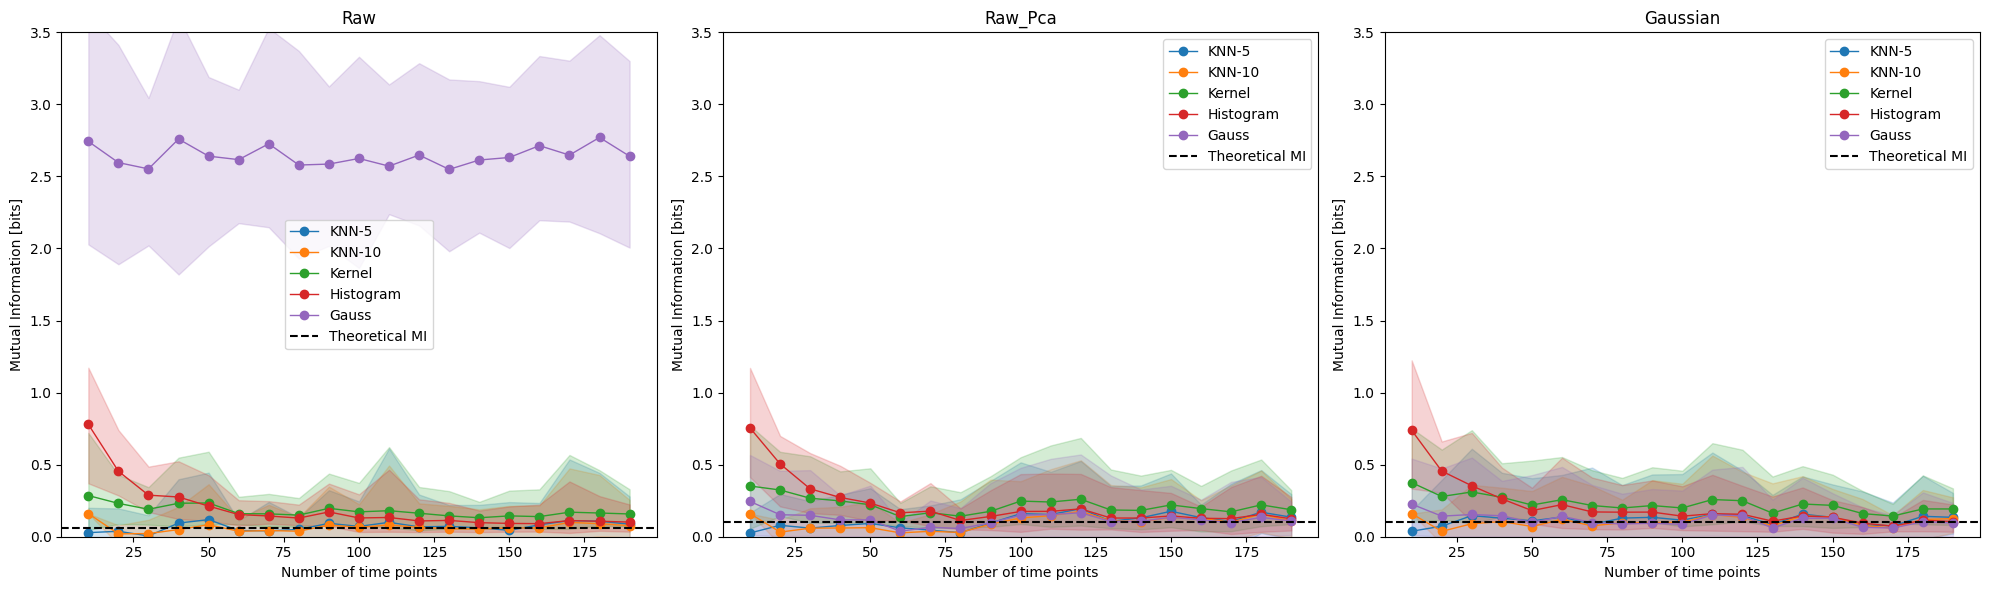

In [21]:
# Group your data variants in a list of tuples: (name, data)
datasets = [
    ("Raw", x_raw),
    ("Raw_Pca", x_raw_pca),
    ("Gaussian", x_gauss)
]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Loop through datasets and corresponding subplot axes
for ax, (name, data) in zip(axes, datasets):
    mi_theoric = theoric_mi(data)
    mi_dict = empirical_mi(data)
    plot_empirical(mi_dict=mi_dict, n_samples=n_samples, mi_theoric_matrix=mi_theoric, ax=ax, ylim=[0,3.5])
    ax.set_title(name)
    

plt.tight_layout()
plt.show()

## 15) Higher Order Interactions (HOI)

In this section, we analyze **higher order interactions** among brain modules by quantifying synergistic and redundant information shared across multiplets (groups) of modules.

---

### Key Concepts

- **Multiplets:** Groups of 3, 4, or 5 brain modules.
- **Synergistic interactions:** Negative HOI values indicating combined information beyond the sum of parts.
- **Redundant interactions:** Positive HOI values indicating shared/repeated information.

We use the **O-information (Oinfo)** model for HOI estimation with two methods:
- **GC (Graphical model based)**
- **KNN (K-nearest neighbors)** for refined evaluation

---

### Workflow Overview

1. **Initial search with GC method:**  
   Find candidate multiplets of sizes 3, 4, and 5 and extract top synergistic and redundant groups.

2. **Evaluate candidates with KNN method:**  
   Refine the estimates by recomputing HOI on selected multiplets using a more robust KNN estimator.

3. **Organize and save the results:**  
   Store top multiplets for further analysis and visualization.

In [22]:
def compute_hoi_for_multiplets(x, multiplets, hoi_model_class, method="knn", **fit_kwargs):
    # Flatten all indices used across multiplets
    hoi_model = hoi_model_class(x, multiplets=multiplets)
    hoi_values = hoi_model.fit(method=method, **fit_kwargs)
    return list(zip(multiplets, hoi_values))


def collect_hoi_df(x, best_multiplets, hoi_model_class, method="knn", **fit_kwargs):
    all_rows = []

    # Dynamically name columns based on HOI model class
    model_name = hoi_model_class.__name__
    if model_name == "TC":
        synergy_col = "Total Correlation (S)"
        redundant_col = "Total Correlation (R)"
    elif model_name == "DTC":
        synergy_col = "Dual Total Correlation (S)"
        redundant_col = "Dual Total Correlation (R)"
    elif model_name == "Sinfo":
        synergy_col = "Shared Information (S)"
        redundant_col = "Shared Information (R)"
    else:
        synergy_col = "Synergistic Value"
        redundant_col = "Redundant Value"

    for size_label in best_multiplets:
        synergistic = best_multiplets[size_label]["synergistic"]
        redundant = best_multiplets[size_label]["redundant"]

        hoi_synergistic = compute_hoi_for_multiplets(x, synergistic, hoi_model_class, method, **fit_kwargs)
        hoi_redundant = compute_hoi_for_multiplets(x, redundant, hoi_model_class, method, **fit_kwargs)

        # Pad shorter list
        max_len = max(len(hoi_synergistic), len(hoi_redundant))
        hoi_synergistic += [("", None)] * (max_len - len(hoi_synergistic))
        hoi_redundant += [("", None)] * (max_len - len(hoi_redundant))

        for (s_m, s_val), (r_m, r_val) in zip(hoi_synergistic, hoi_redundant):
            # Skip rows where both are empty
            if s_m == "" and r_m == "":
                continue
            all_rows.append({
                "Size": size_label,
                "Synergistic Multiplet": s_m,
                synergy_col: float(s_val) if s_val is not None else None,
                "Redundant Multiplet": r_m,
                redundant_col: float(r_val) if r_val is not None else None,
            })

    return pd.DataFrame(all_rows)

In [23]:
def hoi_calculator(model_x, n_1, n_2, n_3, top_k1=5, top_k2=5, top_k3=5, method="gc"):
    # Fit and extract for 3-multiplets
    hoi1 = model_x.fit(method=method, minsize=3, maxsize=3)
    top1 = get_nbest_mult(hoi1, model_x, n_best=n_1)[["order", 'hoi', 'multiplet']]
    top1.columns = ["Order", 'Hoi', 'Multiplet']
    
    # Fit and extract for 4-multiplets
    hoi2 = model_x.fit(method=method, minsize=4, maxsize=4)
    top2 = get_nbest_mult(hoi2, model_x, n_best=n_2)[["order", 'hoi', 'multiplet']]
    top2.columns = ["Order", 'Hoi', 'Multiplet']
    
    # Fit and extract for 5-multiplets
    hoi3 = model_x.fit(method=method, minsize=5, maxsize=5)
    top3 = get_nbest_mult(hoi3, model_x, n_best=n_3)[["order", 'hoi', 'multiplet']]
    top3.columns = ["Order", 'Hoi', 'Multiplet']
    
    # Extract top-k synergy (lowest HOI) and redundancy (highest HOI)
    result = {
        '3-multiplet': {
            'top_redundant': top1[top1['Hoi'] > 0].nlargest(top_k1, 'Hoi').reset_index(drop=True),
            'top_synergistic': top1[top1['Hoi'] < 0].nsmallest(top_k1, 'Hoi').reset_index(drop=True)
        },
        '4-multiplet': {
            'top_redundant': top2[top2['Hoi'] > 0].nlargest(top_k2, 'Hoi').reset_index(drop=True),
            'top_synergistic': top2[top2['Hoi'] < 0].nsmallest(top_k2, 'Hoi').reset_index(drop=True)
        },
        '5-multiplet': {
            'top_redundant': top3[top3['Hoi'] > 0].nlargest(top_k3, 'Hoi').reset_index(drop=True),
            'top_synergistic': top3[top3['Hoi'] < 0].nsmallest(top_k3, 'Hoi').reset_index(drop=True)
        }
    }

    return result

In [24]:
x = x_raw_pca.T.copy()

In [25]:
# Step 1: Initial GC-based search
results_gc = hoi_calculator(
    Oinfo(x),
    n_1=1140,
    n_2=4845,
    n_3=15504,
    top_k1=1140,
    top_k2=4845,
    top_k3=4845,
    method="gc"
)

# Step 2: Define function to evaluate selected multiplets using KNN
def evaluate_knn_for_size(results, size_label):
    synergistic_multiplets = results[f"{size_label}-multiplet"]["top_synergistic"]["Multiplet"].dropna().tolist()
    redundant_multiplets = results[f"{size_label}-multiplet"]["top_redundant"]["Multiplet"].dropna().tolist()

    combined = list({tuple(sorted(m)) for m in synergistic_multiplets + redundant_multiplets})

    oinfo_knn = Oinfo(x, multiplets=combined)
    knn_values = oinfo_knn.fit(method="knn")

    synergistic = [(m, v) for m, v in zip(combined, knn_values) if v < 0]
    redundant = [(m, v) for m, v in zip(combined, knn_values) if v > 0]

    synergistic.sort(key=lambda x: x[1])
    redundant.sort(key=lambda x: -x[1])

    return {
        "synergistic": synergistic,
        "redundant": redundant,
        "combined": combined  # Return for saving
    }

# Step 3: Evaluate all sizes and collect results
best_multiplets_full = {}
best_multiplets_top3 = {}
combined_multiplets_all = {}

for size_label in ["3", "4", "5"]:
    all_results = evaluate_knn_for_size(results_gc, size_label)

    best_multiplets_full[size_label] = {
        "synergistic": all_results["synergistic"],
        "redundant": all_results["redundant"]
    }

    best_multiplets_top3[size_label] = {
        "synergistic": all_results["synergistic"][:3],
        "redundant": all_results["redundant"][:3]
    }

    combined_multiplets_all[size_label] = all_results["combined"]

# Step 4: Save top 3 multiplets
with open("pkl_files/best_multiplets.pkl", "wb") as f:
    pickle.dump(best_multiplets_top3, f)

print("Top 3 best multiplets saved to 'best_multiplets.pkl'")

# Step 5: Save full combined multiplets
with open("pkl_files/combined_multiplets_gc_knn.pkl", "wb") as f:
    pickle.dump(combined_multiplets_all, f)

print("Combined multiplets saved to 'combined_multiplets_gc_knn.pkl'")

# Step 6: Create a table to print best values
max_rows = 10
dfs = {}

for size_label, data in best_multiplets_full.items():
    rows = []
    for i in range(max_rows):
        syn = data["synergistic"][i] if i < len(data["synergistic"]) else (None, None)
        red = data["redundant"][i] if i < len(data["redundant"]) else (None, None)

        syn_m = str(syn[0]) if syn[0] is not None else ""
        syn_o = f"{float(syn[1]):.4f}" if syn[1] is not None else ""

        red_m = str(red[0]) if red[0] is not None else ""
        red_o = f"{float(red[1]):.4f}" if red[1] is not None else ""

        rows.append({
            f"{size_label}-Syn": syn_m,
            f"{size_label}-Syn_Oinfo": syn_o,
            f"{size_label}-Red": red_m,
            f"{size_label}-Red_Oinfo": red_o
        })

    dfs[size_label] = pd.DataFrame(rows)

# Step 7: Concatenate and display
final_df = pd.concat([dfs["3"], dfs["4"], dfs["5"]], axis=1)
print(final_df.to_string())

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Top 3 best multiplets saved to 'best_multiplets.pkl'
Combined multiplets saved to 'combined_multiplets_gc_knn.pkl'
          3-Syn 3-Syn_Oinfo         3-Red 3-Red_Oinfo            4-Syn 4-Syn_Oinfo          4-Red 4-Red_Oinfo                5-Syn 5-Syn_Oinfo             5-Red 5-Red_Oinfo
0    (1, 6, 16)     -0.4232     (5, 8, 9)      0.6629   (2, 6, 16, 18)     -0.4058  (5, 6, 8, 10)      1.2959   (5, 9, 15, 16, 18)     -0.4170  (5, 6, 8, 9, 13)      1.9536
1  (10, 13, 18)     -0.4159    (5, 8, 14)      0.6478   (1, 6, 16, 18)     -0.3813   (4, 5, 6, 8)      1.2743   (1, 6, 13, 18, 19)     -0.4016   (0, 5, 6, 8, 9)      1.9417
2   (6, 13, 17)     -0.4016     (3, 5, 8)      0.6326   (4, 6, 16, 18)     -0.3578  (5, 6, 8, 12)      1.2174   (6, 9, 15, 16, 18)     -0.3807  (0, 5, 6, 8, 12)      1.9269
3    (1, 6, 13)     -0.3930     (0, 5, 8)      0.6234  (4, 13, 14, 15)     -0.3176  (0, 5, 8, 14)      1.2071    (1, 6, 9, 15, 16)     -0.3522   (1, 5, 6, 8, 9)      1.9223
4   (6, 13, 16)     

In [26]:
with open("pkl_files/best_multiplets.pkl", "rb") as f:
    best_multiplets_loaded = pickle.load(f)

In [27]:
# Strip out just the multiplet tuples
stripped_multiplets = {
    size: {
        "synergistic": [m for m, _ in best_multiplets_loaded[size]["synergistic"]],
        "redundant": [m for m, _ in best_multiplets_loaded[size]["redundant"]],
    }
    for size in best_multiplets_loaded
}

### O-Info

In [28]:
df_Oinfo = collect_hoi_df(x, stripped_multiplets, Oinfo, method="knn")
print(df_Oinfo.to_string())
df_Oinfo.to_pickle('pkl_files/df_Oinfo.pkl')
print("DataFrame df_Oinfo saved successfully as 'pkl_files/df_Oinfo.pkl'")

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

  Size Synergistic Multiplet  Synergistic Value Redundant Multiplet  Redundant Value
0    3            (1, 6, 16)          -0.423241           (5, 8, 9)         0.662910
1    3          (10, 13, 18)          -0.415859          (5, 8, 14)         0.647766
2    3           (6, 13, 17)          -0.401581           (3, 5, 8)         0.632629
3    4        (2, 6, 16, 18)          -0.405823       (5, 6, 8, 10)         1.295898
4    4        (1, 6, 16, 18)          -0.381310        (4, 5, 6, 8)         1.274300
5    4        (4, 6, 16, 18)          -0.357796       (5, 6, 8, 12)         1.217407
6    5    (5, 9, 15, 16, 18)          -0.417023    (5, 6, 8, 9, 13)         1.953568
7    5    (1, 6, 13, 18, 19)          -0.401566     (0, 5, 6, 8, 9)         1.941696
8    5    (6, 9, 15, 16, 18)          -0.380737    (0, 5, 6, 8, 12)         1.926926
DataFrame df_Oinfo saved successfully as 'pkl_files/df_Oinfo.pkl'


### TC

In [29]:
df_TC = collect_hoi_df(x, stripped_multiplets, TC, method="knn")
print(df_TC.to_string(index=False))
df_TC.to_pickle('pkl_files/df_TC.pkl')
print("DataFrame df_TC saved successfully as 'pkl_files/df_TC.pkl'")

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Size Synergistic Multiplet  Total Correlation (S) Redundant Multiplet  Total Correlation (R)
   3            (1, 6, 16)               0.096264           (5, 8, 9)               1.286464
   3          (10, 13, 18)               0.717752          (5, 8, 14)               0.868869
   3           (6, 13, 17)               0.289796           (3, 5, 8)               0.772767
   4        (2, 6, 16, 18)               0.566035       (5, 6, 8, 10)               2.152296
   4        (1, 6, 16, 18)               0.539829        (4, 5, 6, 8)               1.715693
   4        (4, 6, 16, 18)               0.109494       (5, 6, 8, 12)               1.907993
   5    (5, 9, 15, 16, 18)               1.126690    (5, 6, 8, 9, 13)               2.039805
   5    (1, 6, 13, 18, 19)               0.651071     (0, 5, 6, 8, 9)               2.747167
   5    (6, 9, 15, 16, 18)               0.765379    (0, 5, 6, 8, 12)               2.052243
DataFrame df_TC saved successfully as 'pkl_files/df_TC.pkl'


### DTC

In [30]:
df_DTC = collect_hoi_df(x, stripped_multiplets, DTC, method="knn")
print(df_DTC.to_string(index=False))
df_DTC.to_pickle('pkl_files/df_DTC.pkl')
print("DataFrame df_DTC saved successfully as 'pkl_files/df_DTC.pkl'")

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Size Synergistic Multiplet  Dual Total Correlation (S) Redundant Multiplet  Dual Total Correlation (R)
   3            (1, 6, 16)                    0.519505           (5, 8, 9)                    0.623554
   3          (10, 13, 18)                    1.133613          (5, 8, 14)                    0.221102
   3           (6, 13, 17)                    0.691378           (3, 5, 8)                    0.140138
   4        (2, 6, 16, 18)                    0.971862       (5, 6, 8, 10)                    0.856397
   4        (1, 6, 16, 18)                    0.921140        (4, 5, 6, 8)                    0.441396
   4        (4, 6, 16, 18)                    0.467291       (5, 6, 8, 12)                    0.690592
   5    (5, 9, 15, 16, 18)                    1.543702    (5, 6, 8, 9, 13)                    0.086239
   5    (1, 6, 13, 18, 19)                    1.052631     (0, 5, 6, 8, 9)                    0.805472
   5    (6, 9, 15, 16, 18)                    1.146109    (0, 5, 6, 8, 12

### Sinfo

In [31]:
df_Sinfo = collect_hoi_df(x, stripped_multiplets, Sinfo, method="knn")
print(df_Sinfo.to_string(index=False))
df_Sinfo.to_pickle('pkl_files/df_Sinfo.pkl')
print("DataFrame df_Sinfo saved successfully as 'pkl_files/df_Sinfo.pkl'")

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Size Synergistic Multiplet  Shared Information (S) Redundant Multiplet  Shared Information (R)
   3            (1, 6, 16)                0.615772           (5, 8, 9)                1.910019
   3          (10, 13, 18)                1.851368          (5, 8, 14)                1.089973
   3           (6, 13, 17)                0.981178           (3, 5, 8)                0.912907
   4        (2, 6, 16, 18)                1.537895       (5, 6, 8, 10)                3.008690
   4        (1, 6, 16, 18)                1.460968        (4, 5, 6, 8)                2.157082
   4        (4, 6, 16, 18)                0.576782       (5, 6, 8, 12)                2.598579
   5    (5, 9, 15, 16, 18)                2.670395    (5, 6, 8, 9, 13)                2.126038
   5    (1, 6, 13, 18, 19)                1.703705     (0, 5, 6, 8, 9)                3.552643
   5    (6, 9, 15, 16, 18)                1.911484    (0, 5, 6, 8, 12)                2.177551
DataFrame df_Sinfo saved successfully as 'pkl_file

### Redundant encoding

In [32]:
# Your original data slices
original_modules_1 = [2, 16, 18]
x2 = x_raw_pca[original_modules_1].T.copy()
y2 = x_raw_pca[6, :].T.copy()

model = GradientOinfo(x2, y2)
hoi = model.fit(method="knn", minsize=3, maxsize=3)
result1 = get_nbest_mult(hoi, model, n_best=3)

# Map local indices back to original modules and sort multiplets
result1_mapped = result1.copy()
result1_mapped['multiplet'] = result1['multiplet'].apply(lambda idxs: sorted([original_modules_1[i] for i in idxs]))
result1_mapped['target_module'] = 16  # The y2 target module index

print("Synergy Multiplets with actual module numbers (sorted):")
print(result1_mapped)


# Second case
original_modules_2 = [5, 8, 10]
x = x_raw_pca[original_modules_2].T.copy()
y = x_raw_pca[6, :].T.copy()


model = GradientOinfo(x, y)
hoi = model.fit(method="knn", minsize=3, maxsize=3)
result2 = get_nbest_mult(hoi, model, n_best=3)

# Map local indices back to original modules and sort multiplets
result2_mapped = result2.copy()
result2_mapped['multiplet'] = result2['multiplet'].apply(lambda idxs: sorted([original_modules_2[i] for i in idxs]))
result2_mapped['target_module'] = 16  # The y target module index

print("Redundancy Multiplets with actual module numbers (sorted):")
print(result2_mapped)

Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets


Synergy Multiplets with actual module numbers (sorted):
   index  order       hoi    multiplet  target_module
0      0      3 -0.176319  [2, 16, 18]             16


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Redundancy Multiplets with actual module numbers (sorted):
   index  order       hoi   multiplet  target_module
0      0      3  0.944481  [5, 8, 10]             16


### RSI

In [33]:
def map_multiplets_to_original(df, original_modules, target_module):
    df_mapped = df.copy()
    df_mapped['multiplet'] = df_mapped['multiplet'].apply(lambda idxs: [original_modules[i] for i in idxs])
    df_mapped['target_module'] = target_module  # Add target module column with the same value for all rows
    return df_mapped

# First case: synergy-like
original_modules_1 = [2, 16, 18]
target_module_1 = 6
x2 = x_raw[original_modules_1].T.copy()
y2 = x_raw[target_module_1, :].T.copy()

model = RSI(x2, y2)
hoi = model.fit(minsize=3, maxsize=5, method="knn")
df_synergy = get_nbest_mult(hoi, model=model, minsize=3, maxsize=3, n_best=3)
df_synergy = map_multiplets_to_original(df_synergy, original_modules_1, target_module_1)
print("Synergistic multiplets with original module numbers:")
print(df_synergy)

# Second case: redundancy-like
original_modules_2 = [5, 8, 10]
target_module_2 = 6
x = x_raw[original_modules_2].T.copy()
y = x_raw[target_module_2, :].T.copy()


model = RSI(x, y)
hoi = model.fit(minsize=3, maxsize=5, method="knn")
df_redundant = get_nbest_mult(hoi, model=model, minsize=3, maxsize=3, n_best=3)
df_redundant = map_multiplets_to_original(df_redundant, original_modules_2, target_module_2)
print("\nRedundant multiplets with original module numbers:")
print(df_redundant)

Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets


Synergistic multiplets with original module numbers:
   index  order       hoi    multiplet  target_module
0      0      3  0.000506  [2, 16, 18]              6


  0%|          |  0/1 [00:00<?,       ?it/s]


Redundant multiplets with original module numbers:
   index  order       hoi   multiplet  target_module
0      0      3 -0.106532  [5, 8, 10]              6


### Integrated Information Decomposition

In [34]:
x = x_raw_pca.T.copy()

df_IID_Syn = collect_hoi_df(x, stripped_multiplets, SynergyphiID, method="knn")
print(df_IID_Syn.to_string())

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

  Size Synergistic Multiplet  Synergistic Value Redundant Multiplet  Redundant Value
0    3            (1, 6, 16)           0.278635           (5, 8, 9)         0.091240
1    3          (10, 13, 18)           0.250686          (5, 8, 14)         0.141149
2    3           (6, 13, 17)           0.337135           (3, 5, 8)         0.134024
3    4        (2, 6, 16, 18)           0.151725       (5, 6, 8, 10)         0.095873
4    4        (1, 6, 16, 18)           0.231852        (4, 5, 6, 8)        -0.055550
5    4        (4, 6, 16, 18)           0.135135       (5, 6, 8, 12)        -0.042723
6    5    (5, 9, 15, 16, 18)          -0.012384    (5, 6, 8, 9, 13)         0.040706
7    5    (1, 6, 13, 18, 19)           0.173442     (0, 5, 6, 8, 9)         0.043182
8    5    (6, 9, 15, 16, 18)          -0.026898    (0, 5, 6, 8, 12)         0.001748


In [35]:
df_IID_Red = collect_hoi_df(x, stripped_multiplets, RedundancyphiID, method="knn")
print(df_IID_Red.to_string())

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets
    Selecting custom multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

  Size Synergistic Multiplet  Synergistic Value Redundant Multiplet  Redundant Value
0    3            (1, 6, 16)           0.001179           (5, 8, 9)         0.148132
1    3          (10, 13, 18)           0.046486          (5, 8, 14)        -0.129848
2    3           (6, 13, 17)          -0.059864           (3, 5, 8)         0.003966
3    4        (2, 6, 16, 18)          -0.084507       (5, 6, 8, 10)        -0.031137
4    4        (1, 6, 16, 18)          -0.084507        (4, 5, 6, 8)        -0.032847
5    4        (4, 6, 16, 18)          -0.153366       (5, 6, 8, 12)        -0.053361
6    5    (5, 9, 15, 16, 18)          -0.082838    (5, 6, 8, 9, 13)        -0.070396
7    5    (1, 6, 13, 18, 19)          -0.084507     (0, 5, 6, 8, 9)        -0.047818
8    5    (6, 9, 15, 16, 18)          -0.084507    (0, 5, 6, 8, 12)        -0.103291


### Redundancy and Synergy MMI

In [36]:
original_modules_1 = [2, 16, 18]
target_module_1 = 6

x = x_raw[original_modules_1].T.copy()
y = x_raw[target_module_1, :].T.copy()

# --- Synergy ---
model_syn = SynergyMMI(x, y)
hoi_syn = model_syn.fit(minsize=3, maxsize=5, method="knn")
df_syn = get_nbest_mult(hoi_syn, model=model_syn, minsize=3, maxsize=3, n_best=3).copy()

# Map internal indices back to original feature indices
df_syn['multiplet'] = df_syn['multiplet'].apply(lambda s: [original_modules_1[i] for i in s])
df_syn['target_module'] = target_module_1  # Add target module column

print("\nSynergy results\n")
print(df_syn)


original_modules_2 = [5, 8, 10]
target_module_2 = 6

x = x_raw[original_modules_2].T.copy()
y = x_raw[target_module_2, :].T.copy()

# --- Redundancy ---
model_red = RedundancyMMI(x, y)
hoi_red = model_red.fit(minsize=3, maxsize=5, method="knn")
df_red = get_nbest_mult(hoi_red, model=model_red, minsize=3, maxsize=3, n_best=3).copy()

df_red['multiplet'] = df_red['multiplet'].apply(lambda s: [original_modules_2[i] for i in s])
df_red['target_module'] = target_module_2  # Add target module column

print("\nRedundancy results\n")
print(df_red)

Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Get list of multiplets



Synergy results

   index  order      hoi    multiplet  target_module
0      0      3 -0.10216  [2, 16, 18]              6


  0%|          |  0/1 [00:00<?,       ?it/s]


Redundancy results

   index  order      hoi   multiplet  target_module
0      0      3  0.11703  [5, 8, 10]              6


## 16) Multiplet Analysis With Higher Order Function

In [37]:
df_Oinfo = pd.read_pickle('pkl_files/df_Oinfo.pkl')
df_Sinfo = pd.read_pickle('pkl_files/df_Sinfo.pkl')
df_TC = pd.read_pickle('pkl_files/df_TC.pkl')
df_DTC = pd.read_pickle('pkl_files/df_DTC.pkl')

In [38]:
x = x_raw_pca
print(x.shape)

summary_data = []
detailed_data = []
joint_mi_rows = []

for i in range(3, 4):
    analyzer = HighOrderInfoAnalyzer(x, n=i)
    analyzer.run(precomputed_oinfo=df_Oinfo, precomputed_sinfo=df_Sinfo, precomputed_TC= df_TC, precomputed_DTC=df_DTC)


    target_subset_syn = stripped_multiplets[str(i)]["synergistic"]
    target_subset_red = stripped_multiplets[str(i)]["redundant"]

    results_syn = analyzer.trace_subset(target_subset_syn)
    results_red = analyzer.trace_subset(target_subset_red)

    for result_type, result_group in [('Synergistic', results_syn), ('Redundant', results_red)]:
        for nplet, oinfo, sinfo, tcinfo, dtcinfo, entropy_dict, h_multi, mutual_info, cm_info, groupwise_cmi, joint_mi in result_group:
            # Basic summary info
            summary_data.append({
                "Order": i,
                "Type": result_type,
                "Nplet": nplet,
                "Oinfo": round(oinfo, 4) if oinfo is not None else None,
                "Sinfo": round(sinfo, 4) if sinfo is not None else None,
                "TC": round(tcinfo, 4) if tcinfo is not None else None,
                "DTC": round(dtcinfo, 4) if dtcinfo is not None else None,
                "Univariate Entropies": " ------- ".join([f"{k}: {float(v):.4f}" for k, v in entropy_dict.items()]),
                "Multivariate Entropy": round(h_multi, 4)
            })

            # Detailed info
            detailed_entry = {
                "Order": i,
                "Type": result_type,
                "Nplet": nplet,
                "Mutual Info": " ------- ".join([f"{k}: {float(v):.4f}" for k, v in mutual_info.items()]),
            }
            detailed_data.append(detailed_entry)
            
            # Joint MI özetini multiplet bazında string olarak oluştur
            if joint_mi is not None:
                parts = []
                for r, bipartitions in joint_mi.items():
                    bipart_strs = []
                    for label, val in bipartitions.items():
                        try:
                            bipart_strs.append(f"{label}={float(val):.4f}")
                        except (ValueError, TypeError):
                            bipart_strs.append(f"{label}={val}")
                    parts.append(f"R = {r}:           " + "       -------       ".join(bipart_strs))  # 8 boşluk
                #joint_mi_str = " | ".join(parts)
                joint_mi_str = "\n".join(parts)

                joint_mi_rows.append({
                    "Order": i,
                    "Type": result_type,
                    "Nplet": nplet,
                    "Joint MI Summary": joint_mi_str
                })


pd.set_option('display.max_colwidth', None)  # Allows full display of string contents
pd.set_option('display.max_rows', None)      # Shows all rows
pd.set_option('display.max_columns', None)   # Shows all columns

# Create DataFrames
df_summary = pd.DataFrame(summary_data)
df_details = pd.DataFrame(detailed_data)
df_joint_mi = pd.DataFrame(joint_mi_rows)


# Print summary
print("\n=== Summary DataFrame ===")
print(df_summary.to_string())

# Print details (optionally show specific columns)
print("\n=== Detailed Metrics DataFrame ===")
print(df_details.to_string())

# Print the Joint MI DataFrame
print("\n=== Joint MI Details by Bipartition Size ===")
display(df_joint_mi.style.set_properties(subset=['Joint MI Summary'], **{'white-space': 'pre-wrap'}))

(20, 190)

=== Summary DataFrame ===
   Order         Type         Nplet   Oinfo   Sinfo      TC     DTC                              Univariate Entropies  Multivariate Entropy
0      3  Synergistic    (1, 6, 16) -0.4232  0.6158  0.0963  0.5195    1: 8.9884 ------- 6: 9.0112 ------- 16: 9.1378               27.0412
1      3  Synergistic  (10, 13, 18) -0.4159  1.8514  0.7178  1.1336  10: 8.3920 ------- 13: 9.6379 ------- 18: 8.5954               25.9075
2      3  Synergistic   (6, 13, 17) -0.4016  0.9812  0.2898  0.6914   6: 9.0112 ------- 13: 9.6379 ------- 17: 9.5557               27.9150
3      3    Redundant     (5, 8, 9)  0.6629  1.9100  1.2865  0.6236     5: 9.5471 ------- 8: 8.0079 ------- 9: 9.3230               25.5915
4      3    Redundant    (5, 8, 14)  0.6478  1.0900  0.8689  0.2211    5: 9.5471 ------- 8: 8.0079 ------- 14: 9.6027               26.2888
5      3    Redundant     (3, 5, 8)  0.6326  0.9129  0.7728  0.1401     3: 9.1555 ------- 5: 9.5471 ------- 8: 8.0079      

,Order,Type,Nplet,Joint MI Summary
0,3,Synergistic,"(1, 6, 16)","R = 1: 1 | (6, 16)=0.3026 ------- 6 | (1, 16)=0.2557 ------- 16 | (1, 6)=0.0790 R = 2: (1, 6) | 16=0.0790 ------- (1, 16) | 6=0.2557 ------- (6, 16) | 1=0.3026"
1,3,Synergistic,"(10, 13, 18)","R = 1: 10 | (13, 18)=0.6457 ------- 13 | (10, 18)=0.6132 ------- 18 | (10, 13)=0.5752 R = 2: (10, 13) | 18=0.5752 ------- (10, 18) | 13=0.6132 ------- (13, 18) | 10=0.6457"
2,3,Synergistic,"(6, 13, 17)","R = 1: 6 | (13, 17)=0.1637 ------- 13 | (6, 17)=0.3948 ------- 17 | (6, 13)=0.3508 R = 2: (6, 13) | 17=0.3508 ------- (6, 17) | 13=0.3948 ------- (13, 17) | 6=0.1637"
3,3,Redundant,"(5, 8, 9)","R = 1: 5 | (8, 9)=0.5779 ------- 8 | (5, 9)=0.5789 ------- 9 | (5, 8)=0.6712 R = 2: (5, 8) | 9=0.6712 ------- (5, 9) | 8=0.5789 ------- (8, 9) | 5=0.5779"
4,3,Redundant,"(5, 8, 14)","R = 1: 5 | (8, 14)=0.4579 ------- 8 | (5, 14)=0.3788 ------- 14 | (5, 8)=0.1587 R = 2: (5, 8) | 14=0.1587 ------- (5, 14) | 8=0.3788 ------- (8, 14) | 5=0.4579"
5,3,Redundant,"(3, 5, 8)","R = 1: 3 | (5, 8)=0.1359 ------- 5 | (3, 8)=0.4446 ------- 8 | (3, 5)=0.3298 R = 2: (3, 5) | 8=0.3298 ------- (3, 8) | 5=0.4446 ------- (5, 8) | 3=0.1359"


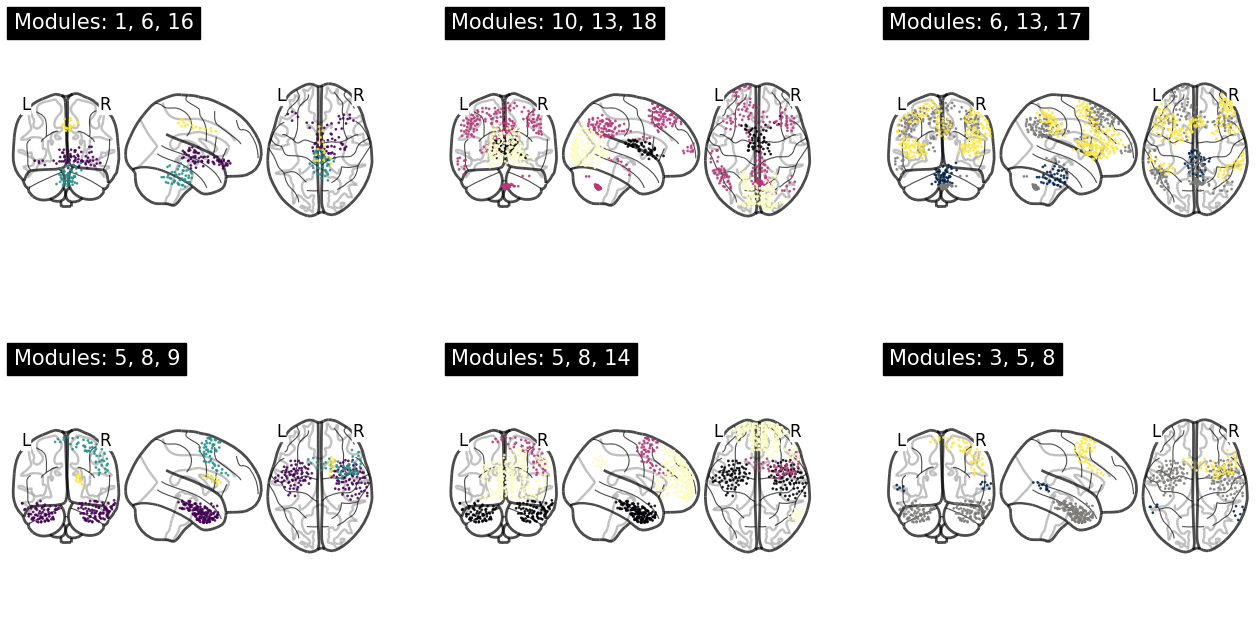

In [39]:
MNI_coords = np.loadtxt("MNI_coords.txt")

def plot_modules_grid(MNI_coords, rsFC_labels, multiplets, cmaps, figsize=(16, 8)):
    """
    Plot multiple multiplets in a grid layout, each colored by its module index.
    
    Parameters:
    - MNI_coords: array of 3D ROI coordinates
    - rsFC_labels: array of module labels for each ROI
    - multiplets: list of lists of module numbers to plot in each subplot
    - cmaps: list of colormaps, one per subplot
    - figsize: figure size for the entire grid
    """
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize,
                             subplot_kw={'xticks': [], 'yticks': []})
    axes = axes.flatten()
    
    for i, (modules, cmap) in enumerate(zip(multiplets, cmaps)):
        all_indices = []
        colors = []
        
        for j, module_num in enumerate(modules):
            inds = np.where(rsFC_labels == module_num)[0]
            all_indices.extend(inds)
            colors.extend([j] * len(inds))  # color by module index
        
        coords = MNI_coords[all_indices]
        colors = np.array(colors)
        
        plot_markers(colors, coords,
                     display_mode='ortho',
                     node_size=1,
                     axes=axes[i],
                     colorbar=False,
                     title="Modules: " + ", ".join(map(str, modules)),
                     node_cmap=cmap,
                     alpha=0.8)
        axes[i].axis('off')
    
    # Hide any unused subplots (in case less than 6)
    for ax in axes[len(multiplets):]:
        ax.axis('off')
    
    plt.show()

# Define multiplets and corresponding colormaps
multiplets = [
    [1, 6, 16],
    [10, 13, 18],
    [6, 13, 17],
    [5, 8, 9],
    [5, 8, 14],
    [3, 5, 8]
]

cmaps = ['viridis', 'magma', 'cividis', 'viridis', 'magma', 'cividis']

plot_modules_grid(MNI_coords, rsFC_labels, multiplets, cmaps)